# Лабораторная работа №4. Семантическая сегментация изображений
Реализация модели сверточной нейронной сети для классификации пикселей, принадлежащих объектам.
В работе используется датасет COCO, расположенный по ссылке http://cocodataset.org/.
Модель натренирована классифицировать пиксели принадлежащие машинам, мотоциклам, самолетам, автобусам и поездам.
В качестве энкодера нейронной сети взята FPN с энкодером Resnet50.
Loss-функция - категориальная кросс-энтропия (categorical cross entropy).
Метрика - точность (accuracy).

## Задача
1. Натренировать сеть для классификации животных из датасета COCO. (10 классов + класс фона).
2. Перепишите класс Dataset. Добавьте легкую аугментацию изображений: зеркалирование изображения относительно вертикальной оси, случайная обрезка кадра.
3. Дописать код, чтобы при обучении давать оценку точности, полноты и F-меры для каждого класса модели. Информацию можно получить по ссылке https://habr.com/ru/company/ods/blog/328372/.

На основании точности, полноты и F-меры для каждого класса сделайте выводы о качестве построенной модели.

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from datetime import datetime
import torch
from torch.utils import data
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Реализация класса Dataset с чтением изображений и аннотаций в виде масок для тренировочного и валидационного датасетов.

In [2]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, subset='train', train_part=0.8):
        super().__init__(root, annFile, transforms=None, transform=None, target_transform=None)
        
        cat_names = ['car',
                     'motorcycle',
                     'airplane',
                     'bus',
                     'train',
                    ]
        
        cats = self.coco.loadCats(self.coco.getCatIds(cat_names))
        
        ids = []
        self.id_to_class, self.class_to_name = dict(), dict()
        self.id_to_class[0] = 0
        self.class_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.class_to_name[it+1] = cat['name']
            
            ids.append(self.coco.getImgIds(catIds=[cat['id']]))
        self.ids = sum(ids, [])
        np.random.seed(1)
        np.random.shuffle(self.ids)
        if subset == 'train':
            self.ids = self.ids[:int(len(self.ids) * train_part)]
        elif subset == 'valid':
            self.ids = self.ids[int(len(self.ids) * train_part):]
            
    def num_classes(self):
        return len(self.id_to_class)
        
    def __getitem__(self, index):

        img, ann = super().__getitem__(index)
        width, height = img.size[:2]

        msk = np.zeros((height, width), dtype=np.uint8)
        for i, it in enumerate(ann):
            if it['category_id'] in self.id_to_class.keys():
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                bw = mask.decode(compressed_rle)

                if len(bw.shape) == 3:
                    bw = np.sum(bw, axis=2)

                msk[np.where(bw != 0)] = self.id_to_class[it['category_id']]
        
        msk = Image.fromarray(msk)
        
        img = img.resize((224,224), resample=2)
        msk = msk.resize((224,224))
        
        img = np.float32(np.array(img)) / 255.
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy())
        
        msk = torch.from_numpy(np.array(msk)).long()

        return img, msk, ann

Создаем объекты класса Dataset для тренировки и валидации.

In [3]:
path_to_images = '/home/vasily/datasets/COCO/images/train2017'
path_to_anno = '/home/vasily/datasets/COCO/annotations/instances_train2017.json'

train_dataset = Dataset(path_to_images, path_to_anno, subset='train')
valid_dataset = Dataset(path_to_images, path_to_anno, subset='valid')

loading annotations into memory...
Done (t=10.31s)
creating index...
index created!
loading annotations into memory...
Done (t=10.92s)
creating index...
index created!


Визуализируем результаты изображения и маски.

In [4]:
img, msk, ann = train_dataset[101]

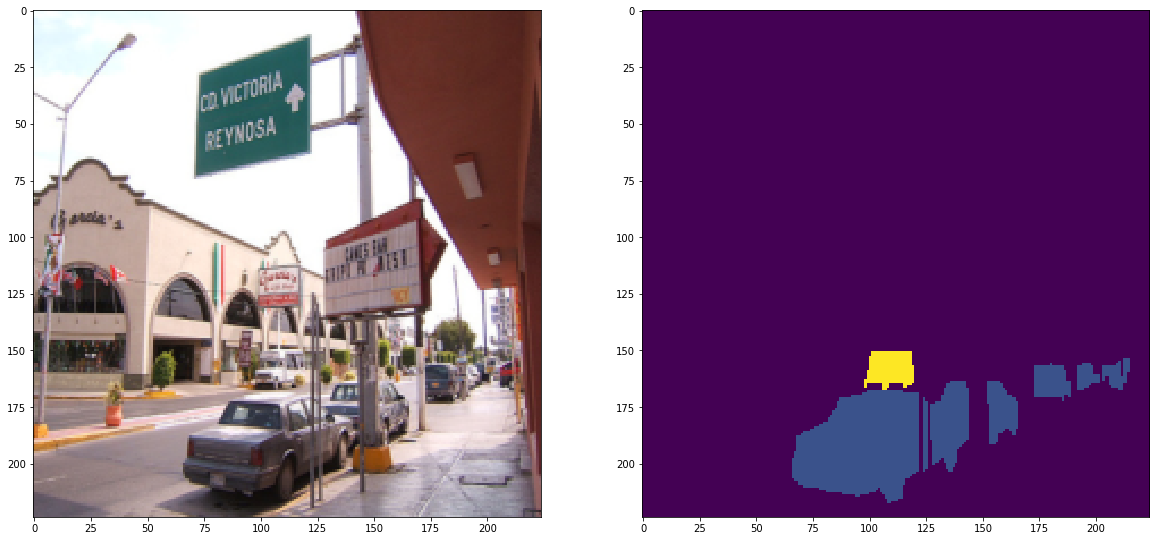

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img.numpy().transpose((1,2,0)))
plt.subplot(122)
plt.imshow(np.squeeze(msk.numpy()))

Создаем загрузчики данных для тренировки.

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

Создаем класс для рассчета и хранения средних значений величин. Далее будем таким образом считать средние значения функции потерь и метрик.

In [8]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

Создаем модели и определяем функцию потерь и метрики. Определяем шаги обучения.

In [11]:
from torch import nn

model = smp.FPN(encoder_name='resnet50', classes=train_dataset.num_classes(), activation='softmax').to(device)

criterion = nn.CrossEntropyLoss()
criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

### Обучение

In [12]:
from tqdm import trange, tqdm

epochs = 10

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} | {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f}', 
              postfix=[0, 'loss', 0, 'acc', 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)
            acc = pixel_acc(outputs, masks)

            loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            
            t.postfix[2] = average_total_loss.average()
            t.postfix[4] = average_acc.average()
            t.update()
    
    # validation
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f}', 
              postfix=[0, 'val_loss', 0, 'val_acc', 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, masks) 
            acc = pixel_acc(outputs, masks)

            average_total_val_loss.update(loss.data.item())
            average_val_acc.update(acc.data.item())
            
            t.postfix[2] = average_total_val_loss.average()
            t.postfix[4] = average_val_acc.average()
            t.update()
        

Training epoch 1 | 1314/1314 04:26<00:00 | loss : 0.3615 | acc : 0.8934
Validation 329/329 00:36<00:00 1 | val_loss : 0.2052 | val_acc : 0.9283
Training epoch 2 | 1314/1314 04:26<00:00 | loss : 0.2032 | acc : 0.9302
Validation 329/329 00:36<00:00 2 | val_loss : 0.1870 | val_acc : 0.9336
Training epoch 3 | 1314/1314 04:26<00:00 | loss : 0.1586 | acc : 0.9437
Validation 329/329 00:36<00:00 3 | val_loss : 0.1770 | val_acc : 0.9388
Training epoch 4 | 1314/1314 04:26<00:00 | loss : 0.1325 | acc : 0.9519
Validation 329/329 00:36<00:00 4 | val_loss : 0.1713 | val_acc : 0.9415
Training epoch 5 | 1314/1314 04:26<00:00 | loss : 0.1177 | acc : 0.9567
Validation 329/329 00:36<00:00 5 | val_loss : 0.1703 | val_acc : 0.9425
Training epoch 6 | 1314/1314 04:26<00:00 | loss : 0.1040 | acc : 0.9611
Validation 329/329 00:36<00:00 6 | val_loss : 0.1814 | val_acc : 0.9446
Training epoch 7 | 1314/1314 04:26<00:00 | loss : 0.0959 | acc : 0.9638
Validation 329/329 00:36<00:00 7 | val_loss : 0.1678 | val_acc :

### Визуальная оценка результатов

In [18]:
img, msk, _ = valid_dataset[100]

In [19]:
sm = nn.Softmax(dim=1)
pred = sm(model(img.expand(1, -1,-1,-1).to(device)))
_, max_pred = torch.max(pred, dim=1)

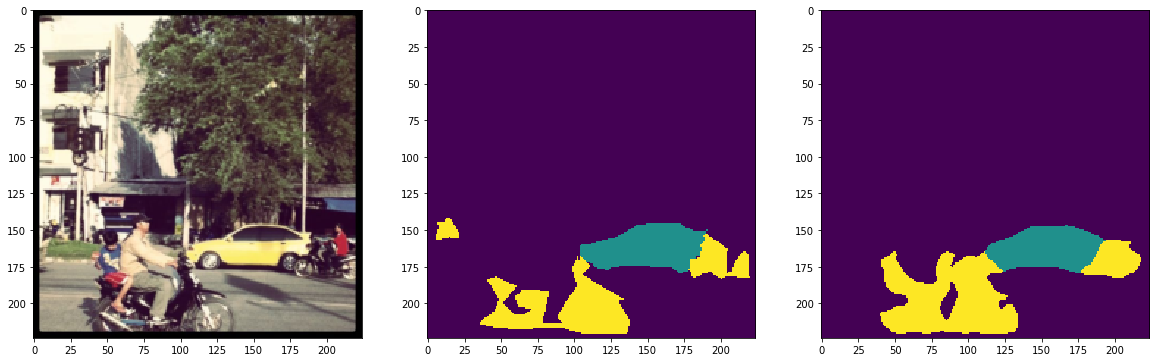

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose((1,2,0)))
plt.subplot(132)
plt.imshow(np.squeeze(msk.numpy()))
plt.subplot(133)
plt.imshow(max_pred[0].detach().cpu().numpy())